In [308]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from highlight_text import fig_text, ax_text

df = pd.read_csv('WHR2024.csv')

# rename column
len_to_remove = len('Explained by: ')
for col in df.columns:
    if 'Explained by: ' in col:
        new_name = col[len_to_remove:]
        df[new_name] = df[col]
        df.drop(col, axis=1, inplace=True)

# create part of each explainer
not_explainers = ['Country name', 'Ladder score',
                  'upperwhisker', 'lowerwhisker', 'total']
explainers = ['Dystopia + residual', 'Log GDP per capita', 'Social support',
              'Healthy life expectancy', 'Freedom to make life choices',
              'Generosity', 'Perceptions of corruption']
for explainer in explainers:
    df['share_'+explainer] = df[explainer]/df['Ladder score']*100

# open and merge with geo data
world = gpd.read_file(
    "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
europe = world[world['CONTINENT'] == 'Europe']
data = europe.merge(
    df, how='left',
    left_on='NAME',
    right_on='Country name'
)
europe.columns
data = data[['geometry']+df.columns.to_list()]
data = data[data['Country name'] != 'Russia']
data.dropna(inplace=True)
data.sample(3)

,geometry,Country name,Ladder score,upperwhisker,lowerwhisker,Dystopia + residual,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,share_Dystopia + residual,share_Log GDP per capita,share_Social support,share_Healthy life expectancy,share_Freedom to make life choices,share_Generosity,share_Perceptions of corruption
15,"POLYGON ((22.65715 44.23492, 22.94483 43.82379...",Bulgaria,5.463,5.569,5.357,1.088,1.629,1.469,0.567,0.620,0.083,0.006,19.915797,29.818781,26.889987,10.378913,11.349076,1.519312,0.109830
6,"POLYGON ((23.48413 53.91250, 23.52754 53.47012...",Poland,6.442,6.513,6.370,1.791,1.738,1.417,0.639,0.600,0.081,0.175,27.801925,26.979199,21.996274,9.919280,9.313878,1.257373,2.716548
29,"POLYGON ((-14.50870 66.45589, -14.73964 65.808...",Iceland,7.525,7.618,7.433,2.050,1.881,1.617,0.718,0.819,0.258,0.182,27.242525,24.996678,21.488372,9.541528,10.883721,3.428571,2.418605


min       0.000000
median    2.574101
max       9.209922
Name: share_Generosity, dtype: float64

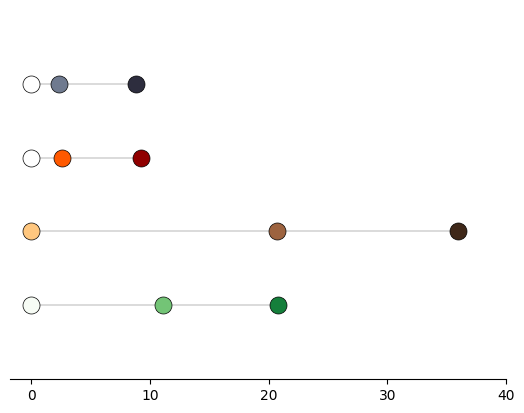

In [278]:

cmaps = [cm.Greens, cm.copper_r, cm.hot_r, cm.bone_r]



fig, ax = plt.subplots()
for i,(cmap,col) in enumerate(zip(cmaps, columns)):

    subset = min_max_df.iloc[i].T

    min_color = cmap(0.0)
    median_color = cmap(0.5)
    max_color = cmap(0.8)
    my_range = i

    ax.scatter(subset['min'], my_range, zorder=2,
               s=150, edgecolor='black', linewidth=0.5, color=min_color)
    ax.scatter(subset['median'], my_range, zorder=2,
               s=150, edgecolor='black', linewidth=0.5, color=median_color)
    ax.scatter(subset['max'], my_range, zorder=2,
               s=150, edgecolor='black', linewidth=0.5, color=max_color)
    
ax.hlines(
    y=range(4),
    xmin=min_max_df['min'],
    xmax=min_max_df['max'],
    color='black',
    linewidth=0.2,
    zorder=1
)
ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_xticks([0, 10, 20, 30, 40])
ax.set_yticks([])
ax.set_ylim(-1, 4)
plt.show()

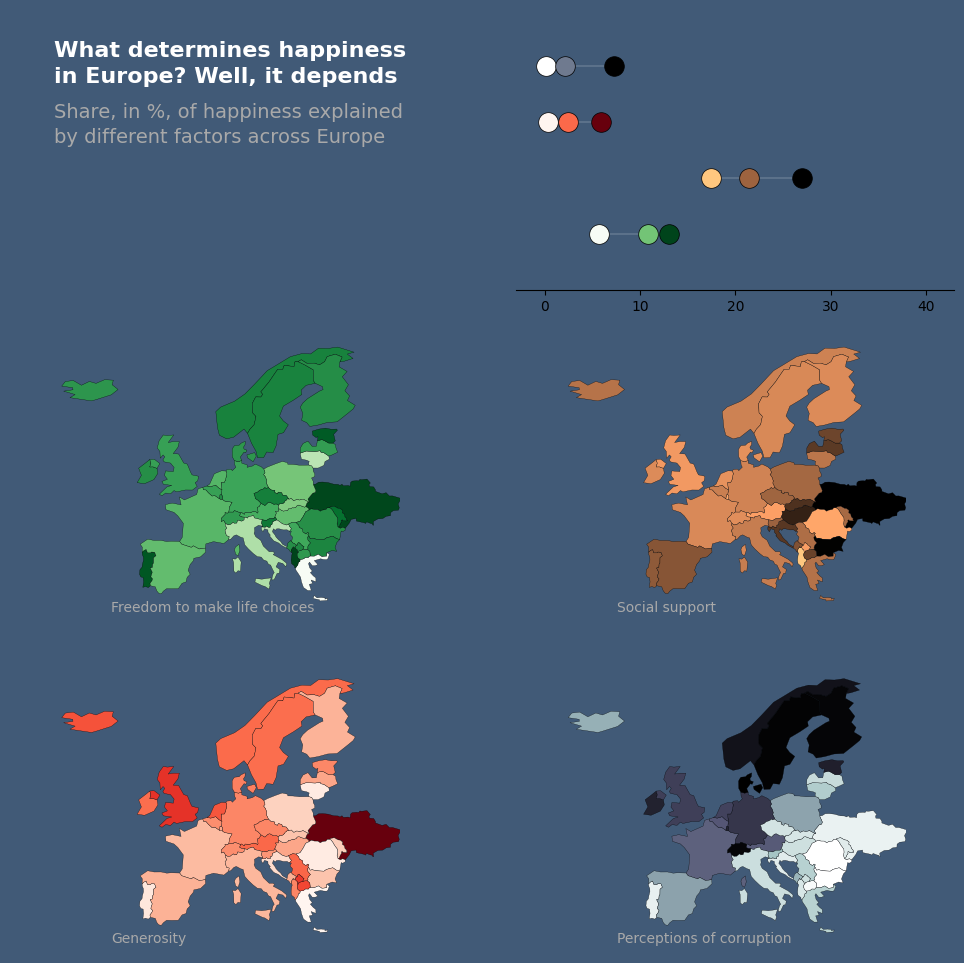

In [313]:
# initialize the figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axs = axs.flatten()

# set background color
background_col = '#415a77'
fig.set_facecolor(background_col)
axs[1].set_facecolor(background_col)

def plot_map_on_ax(column, ax, cmap):

    # define colors
    min_rate, max_rate = data[column].min(), data[column].max()
    norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

    # create the plot
    data.plot(
        column=column,
        cmap=cmap, norm=norm,
        edgecolor='black', linewidth=0.2,
        ax=ax
    )

    # custom axis
    ax.set_xlim(-25, 40)
    ax.set_ylim(32, 72)
    ax.axis('off')

columns = [
    '','',
    'share_Freedom to make life choices',
    'share_Social support',
    'share_Generosity',
    'share_Perceptions of corruption'
]
cmaps = [None, None, cm.Greens, cm.copper_r, cm.Reds, cm.bone_r]
for i, (ax, column, cmap) in enumerate(zip(axs, columns, cmaps)):

    # skip first two axes on top of the maps
    if i in [0,1]:
        continue

    plot_map_on_ax(column=column, ax=ax, cmap=cmap)

    ax_text(
        -15, 34,
        column[6:], # remove the 'share_' in col name
        ha='left', va='center',
        fontsize=10,
        color='darkgrey',
        ax=ax
    )

# Lollipop plot
min_max_df = data[columns[2:]].agg(['min', 'median', 'max']).T
for i, (cmap, col) in enumerate(zip(cmaps[2:], columns[2:])):

    subset = min_max_df.iloc[i].T

    min_color = cmap(0.0)
    median_color = cmap(0.5)
    max_color = cmap(1.0)

    axs[1].scatter(subset['min'], i, zorder=2,
               s=200, edgecolor='black', linewidth=0.5, color=min_color)
    axs[1].scatter(subset['median'], i, zorder=2,
               s=200, edgecolor='black', linewidth=0.5, color=median_color)
    axs[1].scatter(subset['max'], i, zorder=2,
               s=200, edgecolor='black', linewidth=0.5, color=max_color)
axs[1].hlines(
    y=range(4),
    xmin=min_max_df['min'],
    xmax=min_max_df['max'],
    color='white',
    linewidth=0.2,
    zorder=1
)
axs[1].spines[['right', 'top', 'left']].set_visible(False)
axs[1].set_xticks([0, 10, 20, 30, 40])
axs[1].set_yticks([])
axs[1].set_ylim(-1, 4)
axs[1].set_xlim(-3, 43)

# remove top left axis
axs[0].set_axis_off()

# title
text = """
<What determines happiness>
<in Europe? Well, it depends>


<Share, in %, of happiness explained>
<by different factors across Europe>
"""
ax_text(
    0.1, 0.7,
    text,
    ha='left', va='center',
    fontsize=16,
    color='black',
    highlight_textprops=[
        {'fontweight': 'bold',
         'color': 'white'},
        {'fontweight': 'bold',
         'color': 'white'},

        {'color': 'darkgrey',
         'fontsize': 14},
        {'color': 'darkgrey',
         'fontsize': 14}
    ],
    ax=axs[0]
)

# display the plot
fig.tight_layout(pad=2)
fig.savefig('mutliple_maps.png', dpi=300, bbox_inches='tight')
plt.show()

## to change

- remove median from lollipop
- add labels of metrics on lollipop
- change color of x axis on lollipop
- change colormap so that start and end colors are not white and black
- add annotations